# 543 Term Project

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset
import tqdm
from skimage import io
import pandas as pd
import os
import pandas as pd
import imgaug
import numpy as np
import imgaug as ia
from imgaug import augmenters as iaa
import numpy as np
import imageio
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from skimage import io
import wandb
from wandb.keras import WandbCallback
import torch.onnx
from PIL import Image
    
# set device
# device = torch.device('cuda:' if torch.cuda.is_available() else 'cpu')
# device
# torch.cuda.memory_stats(device)


## Dataset

In [2]:

class NaturalImagesDataset(Dataset):
    def __init__(self, csv_file_annot, transform = None):
        self.annotations = pd.read_csv(csv_file_annot,header=None, index_col=False ).values
        self.transform = transform
        
    def __len__(self):
        return self.annotations.shape[0]
    
    def __getitem__(self, index):
        img_path =  self.annotations[index,0]
        image = io.imread(img_path)
        image=Image.fromarray(image)
        y_label =  torch.tensor(int(self.annotations[index,1]))
        if self.transform:
            image =  self.transform(image)
        return (image, y_label)
    
    




In [3]:
data_path = 'data/natural_images/'
dataset_dict = {}
trainset_list = []
testset_list = []
folder_names = sorted(os.listdir(data_path))

# Load Data
for folder in folder_names:
    dataset_dict[folder] = NaturalImagesDataset(csv_file_annot= 'data/'+folder+'.csv', transform=transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((100,100)),
        transforms.ToTensor()        
    ]))

# Split Train and Test
totl, trl, tstl = [], [], []
for folder in folder_names:
    
    length = len(dataset_dict[folder])
    train_size = int(length*0.9)
    test_size =  length-train_size
    totl.append(length), trl.append(train_size), tstl.append(test_size)    
    trainset, testset = torch.utils.data.random_split(dataset_dict[folder], [train_size,test_size])
    trainset_list.append(trainset)
    testset_list.append(testset)

df = pd.DataFrame({'Total Length': totl,'Train':trl, 'Test':tstl}, index=folder_names)
df.loc['Total']= df.sum()
display(df)

# Combine
train_set = torch.utils.data.ConcatDataset(trainset_list)
test_set = torch.utils.data.ConcatDataset(testset_list)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=True)

,Total Length,Train,Test
airplane,727,654,73
car,968,871,97
cat,885,796,89
dog,702,631,71
flower,843,758,85
fruit,1000,900,100
motorbike,788,709,79
person,986,887,99
Total,6899,6206,693


### Visualization

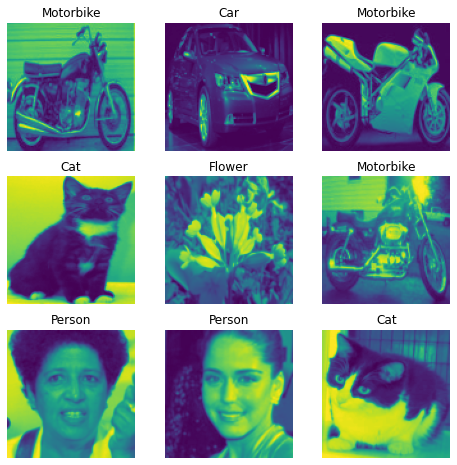

In [4]:
labels_map = {
    0: "Airplane",
    1: "Car",
    2: "Cat",
    3: "Dog",
    4: "Flower",
    5: "Fruit",
    6: "Motorbike",
    7: "Person",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(str(labels_map[label.item()]))
    plt.axis("off")
    plt.imshow(torch.moveaxis(img, 0,-1))
plt.show()

# Models

## CNN Model

In [9]:
class Net(nn.Module):
    def __init__(self, hidden_dim):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, hidden_dim, 3, 1)
        self.conv2 = nn.Conv2d(hidden_dim, 64, 3, 1)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(147456, 1024)
        self.fc2 = nn.Linear(1024,128)
        self.fc3 = nn.Linear(128, 8)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

## MLP Model

In [11]:
class MLP(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.layers = nn.Sequential(
          nn.Flatten(),
          nn.Linear(100 * 100 * 1, hidden_dim),
          nn.ReLU(),
          nn.Linear(hidden_dim, 1024),
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(1024, 128),
          nn.ReLU(),
          nn.Linear(128,8),            
          nn.LogSoftmax(dim=1)
        )
    
    def forward(self, x):
        return self.layers(x)

## Experiment

### Configuration

In [12]:
class Config:
    def __init__(self,name):
        self.model = None
        self.optimizer = None
        self.criterion = F.nll_loss
        self.train_dataloader= None
        self.test_dataloader = None
        self.log_freq = 10
        self.epoch = 15
        self.sweep = {  "name" : "EE543-Project-"+name,
                        "method" : "grid",
                        "parameters" : {
                            "learning_rate" : {
                                # "values" : [0.01]
                                "values" : [0.01, 0.001]
                            },
                            "hidden_dim" :{
                                "values" : [32, 512, 1024]
                                # "values" : [32]
                            },
                            "momentum" :{
                                "values" : [0, 0.5, 0.9]
                                # "values" : [0]
                            }
                        }
                      }
        

### Experiment

In [ ]:
def grid_search(config, model):
    sweep_id = wandb.sweep(config.sweep, entity = "cagnur", project="EE543-Project")
    
    def train():
        wandb.init()
        # Training
        if model == 'cnn':
            config.model = Net(wandb.config.hidden_dim).cuda()
          # config.model = Net(wandb.config.hidden_dim)
        elif model == 'mlp':
            config.model = MLP(wandb.config.hidden_dim).cuda()
        config.optimizer = torch.optim.SGD(config.model.parameters(), lr=wandb.config.learning_rate, momentum=wandb.config.momentum)
        wandb.watch(config.model, config.criterion, log = 'all', log_freq = config.log_freq)
        config.model.train()
        counter = 0
        for epoch in range(config.epoch):            
            for imgs, labels in tqdm.tqdm(config.train_dataloader):
                imgs, labels = imgs.cuda(), labels.cuda()
                # imgs, labels = imgs, labels

                out = config.model(imgs)
                loss = config.criterion(out, labels)
                config.optimizer.zero_grad()
                loss.backward()
                config.optimizer.step()
                counter += 1
                if counter % 5 == 0:
                    wandb.log({'Loss': loss}, step = counter)
        # Training is done
        # Test
        config.model.eval()
        correct = 0
        with torch.no_grad():
            for imgs, labels in tqdm.tqdm(config.test_dataloader):
                imgs, labels = imgs.cuda(), labels.cuda()
                # imgs, labels = imgs, labels
                out = config.model(imgs)
                predictions = out.argmax(dim=1, keepdim=True)  
                correct += predictions.eq(labels.view_as(predictions)).sum().item()
        accuracy = correct/len(config.test_dataloader.dataset)
        wandb.log({"Accuracy":accuracy} )
        # Test is done
        # Export the model   
        torch.onnx.export(config.model,         # model being run 
                         imgs,     # model input (or a tuple for multiple inputs) 
                         "model.onnx",     # where to save the model  
                         export_params=True # store the trained parameter weights inside the model file 
                         )
        wandb.save("model.onnx")
    wandb.agent(sweep_id, function=train)



In [ ]:
torch.cuda.empty_cache()
wandb.login()
config_info = Config('cnn')
config_info.train_dataloader = train_loader
config_info.test_dataloader = test_loader
grid_search(config_info, 'cnn')

In [ ]:
torch.cuda.empty_cache()
wandb.login()
config_info = Config('mlp')
config_info.train_dataloader = train_loader
config_info.test_dataloader = test_loader
grid_search(config_info, 'mlp')